# Project Overview
This notebook serves as a demonstration of various machine learning models for classification on non-linearly separable data. It's important to note that this notebook will not cover data transformations that enable linear separation on multiple planes. This notebook will server more to understand and go over machine learning algorithms.

The dataset used in this notebook consists of two categories that cannot be linearly separated. Our objective is to find a model that yields the best classification results for these categories. To achieve this, I will use several classification algorithms such as logistic regression, k-nearest neighbors, decision trees, random forests and support vector machines. For each of the models I will analyze their performance. Before implementing and evaluating these algorithms, I will provide a explanation of how each one works and discuss their limitations.

Within each algorithm section, I will present the results and provide an interpretation of their meaning and quality. Additionally, at the end of the notebook, I will compare the performance of the different algorithms and determine which ones are most effective for solving this classification problem.

So let's dive into the project. We will begin by importing all the necessary libraries.

In [10]:
# imports
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap # for grgphing decision boundaries
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Loading Data
 The data was generated using the `make_moons` function from the `sklearn` library. To make this more interesting I introduced some noise during the dataset creation process. This adds a layer of complexity and makes the modeling process more intriguing.

To understand the specific details of how the dataset was created, you can refer to the notebook in this repository called `make_dataset.ipynb`. Each model will have its advantages and limitations which we will uncover in this notebook. In the meantime lets laod the data.

In [11]:
data_folder = 'data'

In [12]:
X_train = pd.read_csv(f'./{data_folder}/X_train.csv')
y_train = pd.read_csv(f'./{data_folder}/y_train.csv')
X_test = pd.read_csv(f'./{data_folder}/X_test.csv')
y_test = pd.read_csv(f'./{data_folder}/y_test.csv')

In [13]:
X_train.head()

,x_1,x_2
0,1.543795,-0.242409
1,0.284362,-0.289493
2,-0.818905,0.053129
3,0.991271,0.331274
4,1.181948,0.330166


In [14]:
y_train.head()

,output
0,1
1,1
2,0
3,0
4,0


# Graphing the Data
Down below is some code for graphing the data. First we want to seperate the data by class/output. Doing this will allow us to graph our data with different colors to see the different classes. 

In [15]:
def seperate_categories(df):
    """
    Function to seperate dataframes by class/label.
    Returns two dataframes seperated by label.
    """
    category_zero = df.loc[df['output'] == 0]
    category_one = df.loc[df['output'] == 1]
    return category_zero, category_one

In [16]:
train = pd.concat([X_train, y_train], axis=1)

In [17]:
train

,x_1,x_2,output
0,1.543795,-0.242409,1
1,0.284362,-0.289493,1
2,-0.818905,0.053129,0
3,0.991271,0.331274,0
4,1.181948,0.330166,0
...,...,...,...
1120,-0.159182,0.768414,0
1121,0.533185,0.754607,0
1122,1.120973,-0.339045,1
1123,0.803148,0.695908,0


Below is a graph of our data. As we can see there are two classes. One can be seen in blue and the other one in red. We can also see that it is not linearly seperable. This means that there is not some line we can draw to clearly seperate them. This could be possible if we did some transformation on our data but in this notebook we will skip that. Another thing to mention is that we can see that the data is noisy. By that I mean that we can see that these classes overlap each other at some parts. As I mentioned earlier the first dataset I created had no noise so it was almost like two perfect half circles. This however is noisy. The classes are all over the place. Some examples are even surronded by different classes. Making our data noisy makes modeling and analysing more interesting. Now that we know what our data looks like it is time to model and evaluate. 

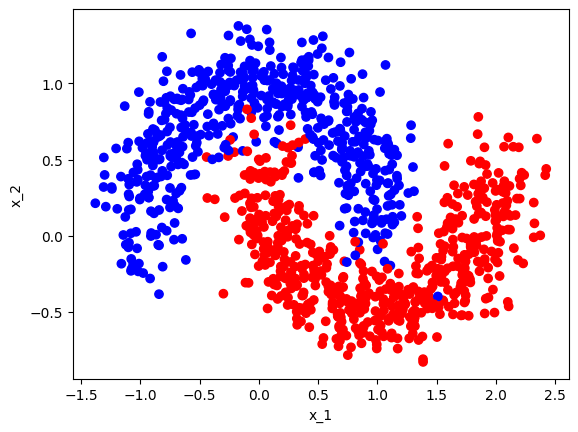

In [18]:
plt.scatter(train.x_1, train.x_2, c=train.output, cmap='bwr',) 
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show();

In [19]:
def graph_boundary(model, class_one, class_two):
    # colors for graphing decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="auto")
    # plot the data by categories 
    plt.scatter(class_one['x_1'], class_one['x_2'], color='r')
    plt.scatter(class_two['x_1'], class_two['x_2'], color='b')
    # set the x and y limits of the graph
    plt.xlim([min(X_train['x_1']), max(X_train['x_1'])])
    plt.ylim([min(X_train['x_2']), max(X_train['x_2'])])
    plt.show()

In [20]:
# reformat data to numpy array so we can use it more easily
y_train = y_train['output']

# Using Logistic Regression
The first classifcation algorithm that I will start with is logistic regression. Logistic regression is a algorithm that we can use for binary classification. It uses the sigmoid function which is defined by:
$$ \sigma(z)= \frac{1}{1+e^{-z}} $$ 
where $z=mx+b$.

Lets take a look at what a sigmoid curve looks like with just taking into consideration `x_1`. 

In [21]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [27]:
x_range = np.linspace(min(train.x_1)-1, max(train.x_1)+1, 100) # range of x_1
y_sigmoid = sigmoid(x_range) # get sigmoid 

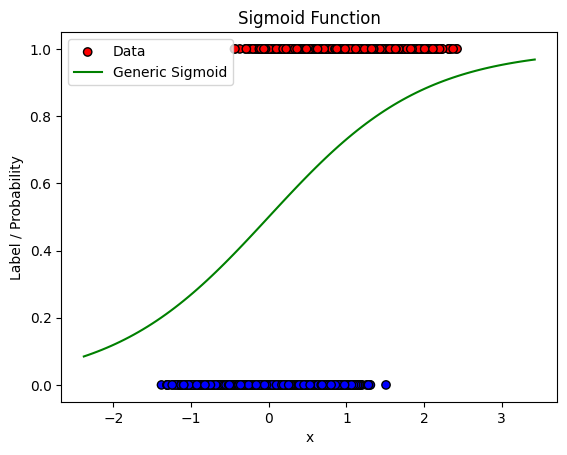

In [28]:
plt.scatter(train.x_1, train.output, c=train.output, cmap='bwr', edgecolor='k', label='Data')
plt.plot(x_range, y_sigmoid, color='green', label='Generic Sigmoid')
plt.xlabel("x")
plt.ylabel("Label / Probability")
plt.title("Sigmoid Function")
plt.legend()
plt.show()

This function returns some value between `0` and `1`. First lets see what we need to do in order to train it. What we want to do is find the correct parameters for this $z=mx+b$ function. Meaning we are trying to find the correct values for `b` and `m`. However because our data has two input features our function looks a little different. Instead of $z=mx+b$ our function will look like $z=m_1+x_1+b_1 + m_2x_2+b_2$. This can be simplified to $\vec{m}\vec{x}+b$ where $\vec{m}$ is a vector holding some weights, $\vec{x}$ is a vector holding our input and b is some vector holding some biases. What we want to do is learn the correct values for m and b. We can do this using gradient descent. 

I wont go over it here but I have a noteobook on my github where I go into more detail [here](https://github.com/GaelGil/notebooks/blob/master/linear_regression/gradient_descent.ipynb). The general idea of gradient descent is that we have some cost function (in our case we would use the log loss.) A los/cost function is a function that tells you how wrong your models output is compared to the real output. What we want to do is minimize the error meaning we want to get is as close to zero as possible. So what we do is take the derivative of our loss function with respect to our model parameters `m` and `b`. In other words how much does `m` and `b` affect our loss. With that information we can move slowly into a direction where our error is close to zero. To predict something we simply pass in our variables into the model $(\frac{1}{1+e^{-z}})$ and we will get back some value between `0` and `1`. Where `1` means it belongs to that class and `0` it doesn't or belongs to another class. Logistic regression has some limitations that I will talk more about later as I analyze the results of the model.

In [32]:
# import model
from sklearn.linear_model import LogisticRegression 

In [33]:
# create the model 
logistic_regression = LogisticRegression()

In [34]:
# train model on the training data
logistic_regression = logistic_regression.fit(X_train, y_train)

Here are the training and the test accuracy. We can see that the scores are fairly high. Although the test score is the lowest of all these algorithms it is still a pretty high score and perfomed even higher than I thought. From these scores we can say that the model classifies most of examples in the dataset correclty but not all. 

In [35]:
f'Training Accuracy: {logistic_regression.score(X_train, y_train)}'

'Training Accuracy: 0.88'

In [36]:
f'Test Accuracy: {logistic_regression.score(X_test, y_test) }'

'Test Accuracy: 0.8746666666666667'

To undertand more about the model and what it is doing there is a couple of graphs below. This will help us understand how the model is predicting and how it's making its decisions. These graphs might be confusing but I will explain what the are below. 

This is a confusion matrix. A confusion matrix can show us more into how our model is working and what it's doing. Let me break down this graph. On the `x-axis` we can see the `Predicted Label` and on the `y-axis` we can see the `True Label`. So if we take a look at the `True Label` for class `1` on the `y-axis` we can see that the `Predicted Label` for 20 of the examples was `0`. Meaning it got those 20 examples incorrect. However we can also see that for the `True Label` of class `1` the `Predicted Label` was `1` 158 times. Meaning it classified those examples correctly. As we can see this validates the statement I said about getting most examples in our training dataset correct. From this we can tell the it perfomes well and the scores are pretty good.

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
confusion_matrix(X_test, y_test)
plt.show() 

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

Lastly, here is a graph of the decision boundary. The decision boundary is the boundary that shows how our model is classifying data. For example here is the graph of the decision boundary for logistic regression for our problem. As we can see there is a line running through both categories/clusters. That line is what the model uses to separate and predict categories. Meaning if we want to classify a new example and it's in the blue section/below the line it will belong to that class.

We can see that the model gets the majority of the data correctly but fails to classify the middle examples. As mentioned earlier we can also see that the logistic regression decision boundary is just a line. This is because logistic regression is best for solving linearly separable problems. What this means is that if we have some data where there are two categories that we can separate and classify them by drawing a line through them. That's why the boundary here is just a line. However because this is non linearly seperable data it can't do any better than that. This is one of the limitations of logistic regression. 

/home/gael/Desktop/git-repos/notebooks/classification_analysis/env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


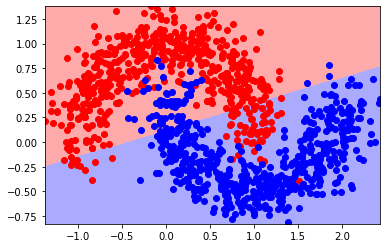

In [18]:
graph_boundary(logistic_regression, class_one, class_two)

The limitations are that it can't learn the data if the data does not have a linear relationship. This can also be seen has logistic regression having a [bias error](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Algorithms that have a bias error are algorithms fail to learn the relationships between their datas inputs and outputs (usually underfit) and thats what logistic regression is doing here. Altough it gets a good amount of examples correct it fails to learn the edges where the data start to overlap but not fully overlap. Another reason for logistic regression having a bias error is for logistic regression making assumptions of the data. It assumes the data will be linear data which this data is not. But it did perform a lot better than I expected. 

# Using KNN
Now we will be using another classification algorithm which is knn (k nearest neighbors). The way this algorithm works is that if we want to classify something we find some odd number $k$. This odd number is the number of how many nearby examples we will check in order to classify. For example if our $k=3$ we will check for the three closests neighbors of our example we are trying to classify. The majority category in those three neighbors is the class that the algorithm predicts. One thing to note is that we check how close the neighbors are by taking the distance from one example to our example. A common distance is the Euclidean distance where distance equals $ d=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2} $ snd $ (x_1,y_1) $ are one point and $ (x_2,y_2) $ is another point. This function returns the distance between those two points. This is how we find what is closest to our example we are trying to classify. 

In [19]:
# import model
from sklearn.neighbors import KNeighborsClassifier

A big part of `k nearest neighbors` is the hyperparameter $k$. Here we have our $k$ equal to seven. As mentioned earlier this is the number of neighbors the algorithm will check to make a prediction. There are many ways we can choose our $k$ one way is just manually trying a bunch of different values and checking what gives us better outcomes. This of course can work but is not a good solution to manualy check because there can be many hyper parameters meaning many combonations. Another way is making some decisions on what would be a good value. For example I knew the number needed to be odd and I knew that if I chose a small odd number like three I could possibly risk overfitting. Here is an example using a number I thought would be a good fit. 

In [20]:
# create model with 7 neighbors to define
manual_knn = KNeighborsClassifier(n_neighbors=7)

In [21]:
# train the model
manual_knn = manual_knn.fit(X_train, y_train)

In [22]:
# get training accuracy
f'Training Accuracy: {manual_knn.fit(X_train, y_train).score(X_train, y_train)}'

'Training Accuracy: 0.9795555555555555'

In [23]:
# get test accuracy
f'Test Accuracy: {manual_knn.score(X_test, y_test)}'

'Test Accuracy: 0.9733333333333334'

Looking at the confusion matrix for this algorithm we can see that it also performs really well. We know it performs better because as if we take a look at the `True label` on the `y-axis` for the class `0` we see that the `Predicted label` for the class `0` (191) is so much higher than for the class `1` (6). This means that it correctly classified those examples. The same can be said for the class `1`. This means that it correctly classifed more exmaples than logistec regression did. This model performed really well. 

/home/gael/Desktop/git-repos/notebooks/classification_analysis/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


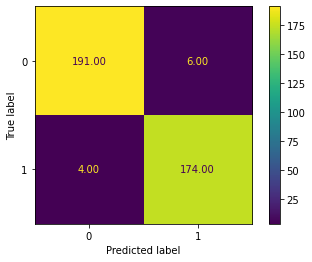

In [24]:
plot_confusion_matrix(manual_knn, X_test, y_test, values_format = '.2f')
plt.show()

The desicion boundary here is very different compared to the logistic regression one. While the logistic regression one was just a straight line through the category the decision boundary for knn circles around both categories seperating them. We can see that it doesn't perfectly classify every example. This can be seen by some blue points in the red boundary and some red points in the blue boundary. But this is a good thing because if it perfectly categories everything then that means that the model is overfitting. If we overfit that means we are memorizing the training data and our model will fail  to correctly classify new examples.

/home/gael/Desktop/git-repos/notebooks/classification_analysis/env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


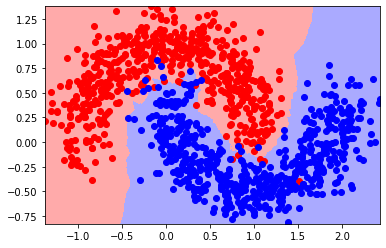

In [25]:
graph_boundary(manual_knn, class_one, class_two)

In the example above I manually set the hyperparameter $k=7$. Another way of getting a hyperparameter is using hyperparameter optimization which is using machine learning to learn which parameters are best for our algorithm. An example of this is [linear regression with gradient desecent](https://github.com/GaelGil/notebooks/blob/master/linear_regression/gradient_descent.ipynb). In gradient descent we take the gradient of the sum of the squared errors to find the best parameters for our algorithm. Here is an example of knn using a method of hyper parameter optimization called grid search. In grid search we provide some values we want to try and

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
grid_search_knn = GridSearchCV(KNeighborsClassifier(),{
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}, return_train_score=False)

In [28]:
# warning: this cell takes a long time to run
grid_search_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11]})

In [29]:
# turn results into dataframe
grid_search_knn_results = pd.DataFrame(grid_search_knn.cv_results_) 

From this dataframe here we can tell that any parameter would be good. Some parameters would give us a slightly better test score but overall they are all good and very similar. A reason for all these parameters being good is because if we take a look at the data graphed. A majority of the data is fairly close to each other meaning the closest neighbor will always be the correct class. However in the edges where the data overlaps this won't always be true. We can see that some red dots are directly next to the majority blue meaning its closest neighbor is not the category it belongs to.

In [30]:
# display grid search results
grid_search_knn_results[['param_n_neighbors', 'mean_test_score']]

,param_n_neighbors,mean_test_score
0,1,0.967111
1,3,0.973333
2,5,0.978667
3,7,0.978667
4,9,0.977778
5,11,0.976889


Here is a graph of how the test score changes as our hyper parameter $k$ increases. We can see that the higher the value is the better the test score is. The biggest visual jump is from $k=1$ to $k=3$.  After that the score increases but then starts to lower. This could possibly because at those values the model starts to overfit. Overall we can see that our manual chosen hyperparameter $k=7$ was a good choce. 

## Warning
One thing to note however is that this graph can be misleading. Although we see that as $k$ changes so does `mean_test_score` the change is so small that if we graphed it with whole numbers they would be in a sraight line with little to no difference. But because we are zoomed in it seems as though there is a drastic change. The change is so small that if we take a look at the numbers they are all pretty much the same  $0.967111, 0.973333, 0.978667, 0.978667$. To better visualize this there is a comment below that you can remove that will plot the data if we were not zoomed in to better understand how small the change is. 

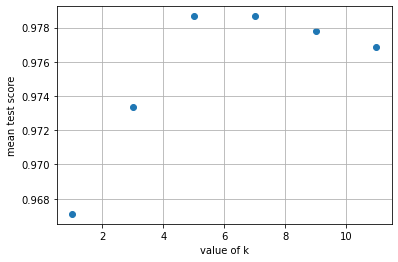

In [31]:
%matplotlib inline 
plt.scatter(grid_search_knn_results['param_n_neighbors'], grid_search_knn_results['mean_test_score'])
plt.xlabel('value of k')
plt.ylabel('mean test score')
plt.grid(True)
# remove the comment below to see how close these values are
# plt.ylim(0, 1.5) 
plt.show();

# Using Decision Trees
Another great classification algorithm is decision trees. The way this model works is the model takes in some data. The model then takes each example and splits them all into binary categories. It stops until there are no more categories we can split the examples into. This can be hard to demonstrated but if we think about each point and we say for example if some `point's` x value is greater than `5` for example. It then belongs to a certain class. If it is smaller then it belongs to something else or we try to put it into a category. We do this for all the points in our dataset. To simplify this the model creates a bunch of if statements that each example fits into until we cant anymore. When we want to classify a new example we just put the example through our tree of if statements and see under which catetgory it lands in. Which ever one it landed in is its class.

In [32]:
# import model
from sklearn import tree

In [33]:
tree_clf = tree.DecisionTreeClassifier()

In [34]:
tree_clf = tree_clf.fit(X_train, y_train)

In [35]:
f'Training Accuracy: {tree_clf.score(X_train, y_train)}'

'Training Accuracy: 1.0'

In [36]:
f'Test Accuracy: {tree_clf.score(X_test, y_test)}'

'Test Accuracy: 0.9733333333333334'

As we can see the decision boundary here has no curves but rather straight lines that take turns left or right. This makes sense of course because as I mentioned earlier our algorithm breaks down everything into binary categories meaning it can go one way or the other and there's no in between. From this graph we can also tell that the model is slightly overfitting at times. We know this because at around `x=1.5` We see a red line in the middle of the blue boundary. We can see that the model is trying to correctly classify that one single red sample in the blue section. This can also bee seen at certain parts of the graph. Although it is overfitting it still performed really well. 

/home/gael/Desktop/git-repos/notebooks/classification_analysis/env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


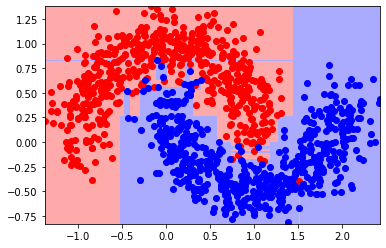

In [37]:
graph_boundary(tree_clf, class_one, class_two)

# Using Random Forests
Now I will be using random forests for the final model.

In [38]:
# import model
from sklearn.ensemble import RandomForestClassifier

Because random forests has some hyper parameters I am going to be using grid search once again to find the best values for those hyperparameters `(hyperparameter optimization)`. Once I have the results we can analyze them and see what will be best for our model.

In [39]:
grid_search_random_forest = GridSearchCV(RandomForestClassifier(),{
    'max_depth': [1, 2, 3, 4, 5, 6],
    'random_state': [0, 1]
}, return_train_score=False)

In [40]:
# perform grid search to find best hyperparamters
grid_search_random_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'random_state': [0, 1]})

In [41]:
# turn the results into a dataframe
grid_search_random_forest_results = pd.DataFrame(grid_search_random_forest.cv_results_)

Here we have the results displayed. We can see that as the `max_depth` increases the `mean_test_score` does as well. The hyperparameter `random_state` however doesn't seem to have such a drastic change to our `mean_test_score`. For example we can see on `row 2` that when our `max_depth` is equal to $2$ and our `random_state` is $0$ it performs slightly better than that of `row 3` where the `max_depth` is the same but our `random_state` is equal to $1$. For this reason I will be using a random state of $0$. If this was confusing I have a visual example below explaining how the `mean_test_score` is affected by the value of our hyperparameters.

In [42]:
# display the results
grid_search_random_forest_results[['param_max_depth', 'param_random_state', 'mean_test_score']]

,param_max_depth,param_random_state,mean_test_score
0,1,0,0.873778
1,1,1,0.887111
2,2,0,0.919111
3,2,1,0.915556
4,3,0,0.923556
5,3,1,0.922667
6,4,0,0.926222
7,4,1,0.929778
8,5,0,0.968889
9,5,1,0.967111


Here are the results above but in a graph. There are two points at each max value because each is being tested with `random_state` true or false. However we can see that the higher the `max_depth` is the better the `mean_test_score`. From the results and this graph we can tell that the best value for our hyperparameter `max_depth` is $6$ and for our other hyperparameter `random_state` the best value is $0$. I will now use these values for our model.

## **Warning**
Once again a reminder that this graph can be misleading. All these scores are very close to each other with only very minor differences. There is a comment below you can removew to see how close these scores are.

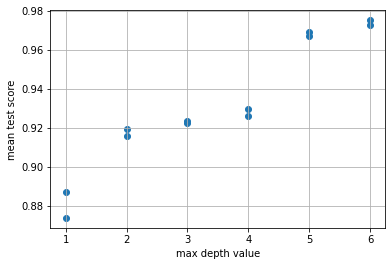

In [43]:
%matplotlib inline 
plt.scatter(grid_search_random_forest_results['param_max_depth'], grid_search_random_forest_results['mean_test_score'])
plt.xlabel('max depth value')
plt.ylabel('mean test score')
plt.grid(True)
# remove the comment below to see how close these values are
# plt.ylim(0, 1.5) 
plt.show();

In [44]:
# use the hyperparameter that we found using grid search
random_forest_clf = RandomForestClassifier(max_depth=6, random_state=0)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=0)

These scores are relly good. Lastly we'll take a look at the decision boundary.`

In [45]:
f'Training Accuracy: {random_forest_clf.score(X_train, y_train)}'

'Training Accuracy: 0.984'

In [46]:
f'Test Accuracy: {random_forest_clf.score(X_test, y_test)}'

'Test Accuracy: 0.976'

From graphing the decision boundary we can see that this model performs well. We can see that unlike decision trees this model does not overfit by trying to get everything correctly. By that I mean that the decision boundary doesn't overstep into the red points to classify one blue point. 

/home/gael/Desktop/git-repos/notebooks/classification_analysis/env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


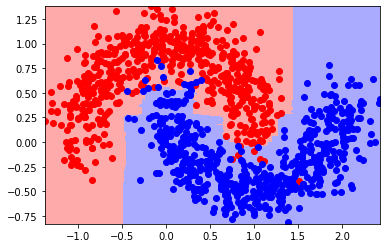

In [47]:
graph_boundary(random_forest_clf, class_one, class_two)

# Conclusion

In conclusion, although logistic regression performed better than initially expected in terms of its overall accuracy score, its inherent bias error and limitations make it unsuitable for handling this particular dataset. Its bias error prevents it from effectively learning non-linearly separable data, which is the primary objective in this case. Despite achieving a relatively high score, we know that better alternatives exist.

K Nearest Neighbors (KNN) was initially expected to be the top-performing algorithm. While it demonstrated impressive performance, it exhibited limitations due to its variance error, resulting in overfitting as observed from the decision boundary plot.

Decision trees also delivered satisfactory results, but its high variance error was evident through significant overfitting. Although it effectively classified the non-linear data, concerns arise regarding its performance with noisier data or increased class overlap. This model proved to be a suitable classifier for the non-linearly separable data, but its viability may diminish in more challenging scenarios.

Lastly, random forests were relatively unfamiliar to me at the start of this project. Initially assuming similarities to decision trees, I anticipated potential overfitting and high variance error. The ability to explore hyperparameters twice in this notebook was interesting, providing an opportunity to delve into hyperparameter optimization with multiple parameters. Ultimately, the random forests algorithm performed exceptionally well without significant overfitting, making it the most favorable solution. Unlike KNN, it did not exhibit overfitting even at the best value for the hyperparameter, k. Therefore, it is the most suitable algorithm for solving our classification problem.

All of the algorithms demonstrated strong performance in tackling the task of classifying non-linearly separable data, even including logistic regression, which initially seemed less promising. Each algorithm exhibited its own bias and variance errors and had distinct limitations, but overall, they all performed admirably. Through this project, I acquired valuable insights into machine learning algorithms, and it highlighted the importance of data transformations in enhancing logistic regression's performance. This project served as a valuable learning experience, introducing various tools for implementing machine learning algorithms, and I am excited to continue expanding my knowledge in this field.